<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">
*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb) | [Contents](Index.ipynb) | [Application: A Face Detection Pipeline](05.14-Image-Features.ipynb) >

# In-Depth: Kernel Density Estimation

In the previous section we covered Gaussian mixture models (GMM), which are a kind of hybrid between a clustering estimator and a density estimator.
Recall that a density estimator is an algorithm which takes a $D$-dimensional dataset and produces an estimate of the $D$-dimensional probability distribution which that data is drawn from.
The GMM algorithm accomplishes this by representing the density as a weighted sum of Gaussian distributions.
*Kernel density estimation* (KDE) is in some senses an algorithm which takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component *per point*, resulting in an essentially non-parametric estimator of density.
In this section, we will explore the motivation and uses of KDE.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating KDE: Histograms

As already discussed, a density estimator is an algorithm which seeks to model the probability distribution that generated a dataset.
For one dimensional data, you are probably already familiar with one simple density estimator: the histogram.
A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

For example, let's create some data that is drawn from two normal distributions:

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

We have previously seen that the standard count-based histogram can be created with the ``plt.hist()`` function.
By specifying the ``normed`` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density:

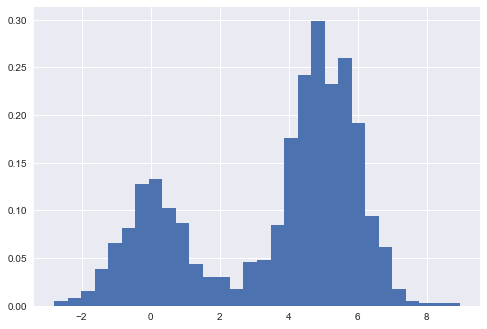

In [3]:
hist = plt.hist(x, bins=30, normed=True)

Notice that for equal binning, this normalization simply changes the scale on the y-axis, leaving the relative heights essentially the same as in a histogram built from counts.
This normalization is chosen so that the total area under the histogram is equal to 1, as we can confirm by looking at the output of the histogram function:

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features.
For example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data!
Consider this example:

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

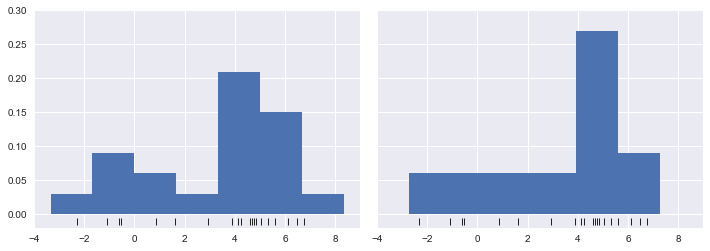

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

On the left, the histogram makes clear that this is a bimodal distribution.
On the right, we see a unimodal distribution with a long tail.
Without seeing the preceding code, you would probably not guess that these two histograms were built from the same data: with that in mind, how can you trust the intuition that histograms confer?
And how might we improve on this?

Stepping back, we can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset.
Let's view this directly:

(-0.2, 8)

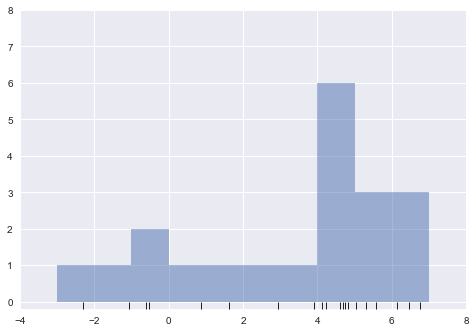

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

The problem with our two binnings stems from the fact that the height of the block stack often reflects not on the actual density of points nearby, but on coincidences of how the bins align with the data points.
This mis-alignment between points and their blocks is a potential cause of the poor histogram results seen here.
But what if, instead of stacking the blocks aligned with the *bins*, we were to stack the blocks aligned with the *points they represent*?
If we do this, the blocks won't be aligned, but we can add their contributions at each location along the x-axis to find the result.
Let's try this:

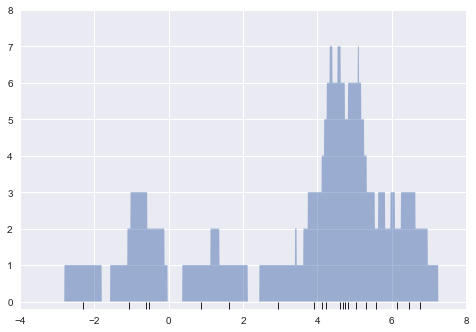

In [8]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

The result looks a bit messy, but is a much more robust reflection of the actual data characteristics than is the standard histogram.
Still, the rough edges are not aesthetically pleasing, nor are they reflective of any true properties of the data.
In order to smooth them out, we might decide to replace the blocks at each location with a smooth function, like a Gaussian.
Let's use a standard normal curve at each point instead of a block:

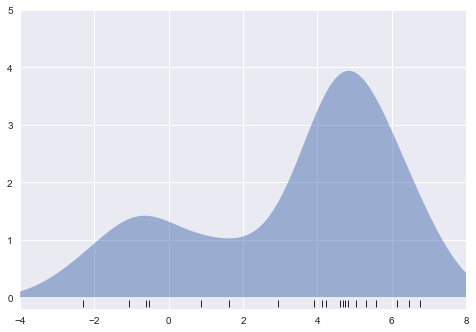

In [9]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

This smoothed-out plot, with a Gaussian distribution contributed at the location of each input point, gives a much more accurate idea of the shape of the data distribution, and one which has much less variance (i.e., changes much less in response to differences in sampling).

These last two plots are examples of kernel density estimation in one dimension: the first uses a so-called "tophat" kernel and the second uses a Gaussian kernel.
We'll now look at kernel density estimation in more detail.

## Kernel Density Estimation in Practice

The free parameters of kernel density estimation are the *kernel*, which specifies the shape of the distribution placed at each point, and the *kernel bandwidth*, which controls the size of the kernel at each point.
In practice, there are many kernels you might use for a kernel density estimation: in particular, the Scikit-Learn KDE implementation supports one of six kernels, which you can read about in Scikit-Learn's [Density Estimation documentation](http://scikit-learn.org/stable/modules/density.html).

While there are several versions of kernel density estimation implemented in Python (notably in the SciPy and StatsModels packages), I prefer to use Scikit-Learn's version because of its efficiency and flexibility.
It is implemented in the ``sklearn.neighbors.KernelDensity`` estimator, which handles KDE in multiple dimensions with one of six kernels and one of a couple dozen distance metrics.
Because KDE can be fairly computationally intensive, the Scikit-Learn estimator uses a tree-based algorithm under the hood and can trade off computation time for accuracy using the ``atol`` (absolute tolerance) and ``rtol`` (relative tolerance) parameters.
The kernel bandwidth, which is a free parameter, can be determined using Scikit-Learn's standard cross validation tools as we will soon see.

Let's first show a simple example of replicating the above plot using the Scikit-Learn ``KernelDensity`` estimator:

(-0.02, 0.22)

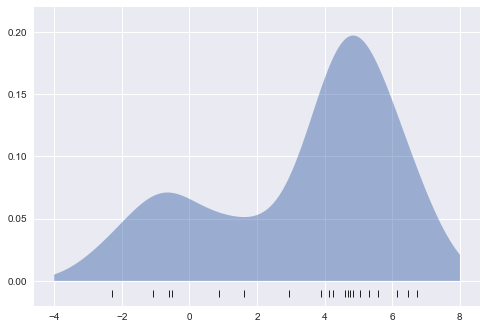

In [10]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

The result here is normalized such that the area under the curve is equal to 1.

### Selecting the bandwidth via cross-validation

The choice of bandwidth within KDE is extremely important to finding a suitable density estimate, and is the knob that controls the bias–variance trade-off in the estimate of density: too narrow a bandwidth leads to a high-variance estimate (i.e., over-fitting), where the presence or absence of a single point makes a large difference. Too wide a bandwidth leads to a high-bias estimate (i.e., under-fitting) where the structure in the data is washed out by the wide kernel.

There is a long history in statistics of methods to quickly estimate the best bandwidth based on rather stringent assumptions about the data: if you look up the KDE implementations in the SciPy and StatsModels packages, for example, you will see implementations based on some of these rules.

In machine learning contexts, we've seen that such hyperparameter tuning often is done empirically via a cross-validation approach.
With this in mind, the ``KernelDensity`` estimator in Scikit-Learn is designed such that it can be used directly within the Scikit-Learn's standard grid search tools.
Here we will use ``GridSearchCV`` to optimize the bandwidth for the preceding dataset.
Because we are looking at such a small dataset, we will use leave-one-out cross-validation, which minimizes the reduction in training set size for each cross-validation trial:

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(x)))
grid.fit(x[:, None]);

Now we can find the choice of bandwidth which maximizes the score (which in this case defaults to the log-likelihood):

In [15]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

The optimal bandwidth happens to be very close to what we used in the example plot earlier, where the bandwidth was 1.0 (i.e., the default width of ``scipy.stats.norm``).

## Example: KDE on a Sphere

Perhaps the most common use of KDE is in graphically representing distributions of points.
For example, in the Seaborn visualization library (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)), KDE is built in and automatically used to help visualize points in one and two dimensions.

Here we will look at a slightly more sophisticated use of KDE for visualization of distributions.
We will make use of some geographic data that can be loaded with Scikit-Learn: the geographic distributions of recorded observations of two South American mammals, *Bradypus variegatus* (the Brown-throated Sloth) and *Microryzomys minutus* (the Forest Small Rice Rat).

With Scikit-Learn, we can fetch this data as follows:

In [16]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

HTTPError: HTTP Error 404: Not Found

With this data loaded, we can use the Basemap toolkit (mentioned previously in [Geographic Data with Basemap](04.13-Geographic-Data-With-Basemap.ipynb)) to plot the observed locations of these two species on the map of South America.

In [ ]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

# plot coastlines with basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);

Unfortunately, this doesn't give a very good idea of the density of the species, because points in the species range may overlap one another.
You may not realize it by looking at this plot, but there are over 1,600 points shown here!

Let's use kernel density estimation to show this distribution in a more interpretable way: as a smooth indication of density on the map.
Because the coordinate system here lies on a spherical surface rather than a flat plane, we will use the ``haversine`` distance metric, which will correctly represent distances on a curved surface.

There is a bit of boilerplate code here (one of the disadvantages of the Basemap toolkit) but the meaning of each code block should be clear:

In [ ]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # plot coastlines with basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # construct a spherical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

Compared to the simple scatter plot we initially used, this visualization paints a much clearer picture of the geographical distribution of observations of these two species.

## Example: Not-So-Naive Bayes

This example looks at Bayesian generative classification with KDE, and demonstrates how to use the Scikit-Learn architecture to create a custom estimator.

In [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb), we took a look at naive Bayesian classification, in which we created a simple generative model for each class, and used these models to build a fast classifier.
For Gaussian naive Bayes, the generative model is a simple axis-aligned Gaussian.
With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class.
It's still Bayesian classification, but it's no longer naive.

The general approach for generative classification is this:

1. Split the training data by label.

2. For each set, fit a KDE to obtain a generative model of the data.
   This allows you for any observation $x$ and label $y$ to compute a likelihood $P(x~|~y)$.
   
3. From the number of examples of each class in the training set, compute the *class prior*, $P(y)$.

4. For an unknown point $x$, the posterior probability for each class is $P(y~|~x) \propto P(x~|~y)P(y)$.
   The class which maximizes this posterior is the label assigned to the point.

The algorithm is straightforward and intuitive to understand; the more difficult piece is couching it within the Scikit-Learn framework in order to make use of the grid search and cross-validation architecture.

This is the code that implements the algorithm within the Scikit-Learn framework; we will step through it following the code block:

In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### The anatomy of a custom estimator

Let's step through this code and discuss the essential features:

```python
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
```

Each estimator in Scikit-Learn is a class, and it is most convenient for this class to inherit from the ``BaseEstimator`` class as well as the appropriate mixin, which provides standard functionality.
For example, among other things, here the ``BaseEstimator`` contains the logic necessary to clone/copy an estimator for use in a cross-validation procedure, and ``ClassifierMixin`` defines a default ``score()`` method used by such routines.
We also provide a doc string, which will be captured by IPython's help functionality (see [Help and Documentation in IPython](01.01-Help-And-Documentation.ipynb)).

Next comes the class initialization method:

```python
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
```

This is the actual code that is executed when the object is instantiated with ``KDEClassifier()``.
In Scikit-Learn, it is important that *initialization contains no operations* other than assigning the passed values by name to ``self``.
This is due to the logic contained in ``BaseEstimator`` required for cloning and modifying estimators for cross-validation, grid search, and other functions.
Similarly, all arguments to ``__init__`` should be explicit: i.e. ``*args`` or ``**kwargs`` should be avoided, as they will not be correctly handled within cross-validation routines.

Next comes the ``fit()`` method, where we handle training data:

```python 
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
```

Here we find the unique classes in the training data, train a ``KernelDensity`` model for each class, and compute the class priors based on the number of input samples.
Finally, ``fit()`` should always return ``self`` so that we can chain commands. For example:
```python
label = model.fit(X, y).predict(X)
```
Notice that each persistent result of the fit is stored with a trailing underscore (e.g., ``self.logpriors_``).
This is a convention used in Scikit-Learn so that you can quickly scan the members of an estimator (using IPython's tab completion) and see exactly which members are fit to training data.

Finally, we have the logic for predicting labels on new data:
```python
    def predict_proba(self, X):
        logprobs = np.vstack([model.score_samples(X)
                              for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
```
Because this is a probabilistic classifier, we first implement ``predict_proba()`` which returns an array of class probabilities of shape ``[n_samples, n_classes]``.
Entry ``[i, j]`` of this array is the posterior probability that sample ``i`` is a member of class ``j``, computed by multiplying the likelihood by the class prior and normalizing.

Finally, the ``predict()`` method uses these probabilities and simply returns the class with the largest probability.

### Using our custom estimator

Let's try this custom estimator on a problem we have seen before: the classification of hand-written digits.
Here we will load the digits, and compute the cross-validation score for a range of candidate bandwidths using the ``GridSearchCV`` meta-estimator (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)):

In [18]:
from sklearn.datasets import load_digits
from sklearn.grid_search import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = [val.mean_validation_score for val in grid.grid_scores_]

Next we can plot the cross-validation score as a function of bandwidth:

{'bandwidth': 7.0548023107186433}
accuracy = 0.9666110183639399


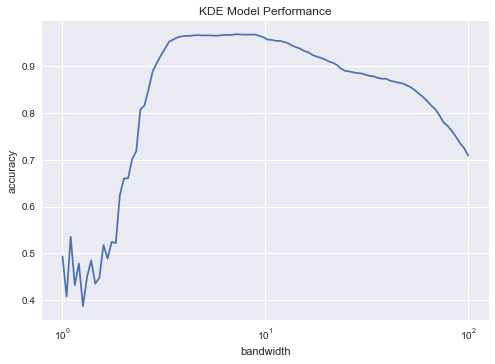

In [19]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

We see that this not-so-naive Bayesian classifier reaches a cross-validation accuracy of just over 96%; this is compared to around 80% for the naive Bayesian classification:

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.81860038035501381

One benefit of such a generative classifier is interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a *full model* of the distribution of points we are comparing it to!
If desired, this offers an intuitive window into the reasons for a particular classification that algorithms like SVMs and random forests tend to obscure.

If you would like to take this further, there are some improvements that could be made to our KDE classifier model:

- we could allow the bandwidth in each class to vary independently
- we could optimize these bandwidths not based on their prediction score, but on the likelihood of the training data under the generative model within each class (i.e. use the scores from ``KernelDensity`` itself rather than the global prediction accuracy)

Finally, if you want some practice building your own estimator, you might tackle building a similar Bayesian classifier using Gaussian Mixture Models instead of KDE.

<!--NAVIGATION-->
< [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb) | [Contents](Index.ipynb) | [Application: A Face Detection Pipeline](05.14-Image-Features.ipynb) >